<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/Instruments_curl%2C_parse_2021_9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [1]:
from icevision.all import *

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:69
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

In [ ]:
import icevision
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

In [ ]:
# using roboflow annotation of 10 instrument images
# https://app.roboflow.com/maria-rodriguez

# copy !curl export jupyter mode

In [ ]:
!curl -L "https://app.roboflow.com/ds/zKigl40E3V?key=0kRK9DYvXZ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [33]:
data_dir = Path('./train')
data_dir.ls()

(#22) [Path('train/mosquito3_jpeg.rf.b3c337c2442ea100f0a85f78554c280a.jpg'),Path('train/mix_jpeg.rf.db669a2442950ef4b09d895ae6e91be5.jpg'),Path('train/mix2_jpeg.rf.4555b708ada8340dfbfa53dbc5e5552a.jpg'),Path('train/mix4_jpeg.rf.4e1a962661ff732e3017caa8e6bbadc3.jpg'),Path('train/mosquito3_jpeg.rf.ea6ffe4ed6aeeb8429e3e80bc46e5ebf.jpg'),Path('train/mix_jpeg.rf.231f157a43ea17c7fb9ac5b32a56e4ab.jpg'),Path('train/mix5_jpeg.rf.4dfb6cdb7e31dc46c6f82c114c1e2036.jpg'),Path('train/mix5_jpeg.rf.699a622205cf25288c2771027f5f2977.jpg'),Path('train/mix3_jpeg.rf.daac2abe9e8cae877c77785008dfaaaf.jpg'),Path('train/mix5_jpeg.rf.5b093e6deb0a5eca0cf39d3dca0c6074.jpg')...]

In [34]:
import pandas as pd
df = pd.read_csv('train/_annotations.csv')
df.rename(columns={'class':'label'}, inplace=True)
df.head()

,filename,width,height,label,xmin,ymin,xmax,ymax
0,mosquito3_jpeg.rf.362d938a074faef940c78802f85690d7.jpg,416,416,mosquito clamp,181,56,288,275
1,mosquito3_jpeg.rf.362d938a074faef940c78802f85690d7.jpg,416,416,mosquito clamp,112,80,222,305
2,mix4_jpeg.rf.133d8bafec4bd085337e7cf7d9afdcb7.jpg,416,416,fine needle holder,108,86,310,259
3,mix4_jpeg.rf.133d8bafec4bd085337e7cf7d9afdcb7.jpg,416,416,scalpel handle,104,35,299,106
4,mix4_jpeg.rf.133d8bafec4bd085337e7cf7d9afdcb7.jpg,416,416,mayo scissors,301,148,407,374


In [10]:
df.filename.nunique()
# 10 original images
# 21 includes augmentations

21

In [11]:
df.label.nunique()

13

In [35]:
_CLASSES = df.label.unique().tolist()
_CLASSES

['mosquito clamp',
 'fine needle holder',
 'scalpel handle',
 'mayo scissors',
 'fine scissors',
 'fine forceps',
 'metz scissors',
 'short metz scissors',
 'towel clip',
 'zen retractor',
 'forceps',
 'self retractor',
 'needle holder']

In [36]:
class_map = ClassMap(_CLASSES)
class_map.get_by_name('needle holder')

13

In [37]:
data_dir = Path('./train')

template_record = ObjectDetectionRecord()

class InstrumentParser(Parser):
  def __init__(self, template_record, data_dir):
    super().__init__(template_record = template_record)

    self.data_dir = data_dir # data_dir = Path('./train')
    self.df = df 
    self.class_map = class_map # class_map = ClassMap(_CLASSES)

  def __iter__(self) -> Any:
    for o in self.df.itertuples():
      yield o

  def __len__(self) -> int:
    return len(self.df)

  def record_id(self, o) -> Hashable:
    return o.filename

  def parse_fields(self, o, record, is_new):
    if is_new:
      record.set_filepath(self.data_dir / o.filename)#
      record.set_img_size(ImgSize(width = o.width, height = o.height))#
      record.detection.set_class_map(self.class_map)

    record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
    record.detection.add_labels([o.label])

## may need to revise parse fields

In [38]:
parser = InstrumentParser(template_record, data_dir)

train_records, valid_records = parser.parse()

  0%|          | 0/108 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

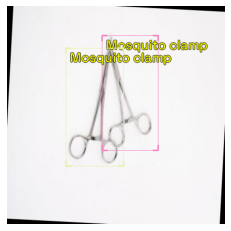

In [39]:
show_record(train_records[0], class_map=class_map, font_size=25,
            label_color = '#ffff00')

In [40]:
train_records[0]

BaseRecord

common: 
	- Record ID: 0
	- Image size ImgSize(width=416, height=416)
	- Filepath: train/mosquito3_jpeg.rf.362d938a074faef940c78802f85690d7.jpg
	- Img: None
detection: 
	- Class Map: <ClassMap: {'background': 0, 'mosquito clamp': 1, 'fine needle holder': 2, 'scalpel handle': 3, 'mayo scissors': 4, 'fine scissors': 5, 'fine forceps': 6, 'metz scissors': 7, 'short metz scissors': 8, 'towel clip': 9, 'zen retractor': 10, 'forceps': 11, 'self retractor': 12, 'needle holder': 13}>
	- Labels: [1, 1]
	- BBoxes: [<BBox (xmin:181, ymin:56, xmax:288, ymax:275)>, <BBox (xmin:112, ymin:80, xmax:222, ymax:305)>]

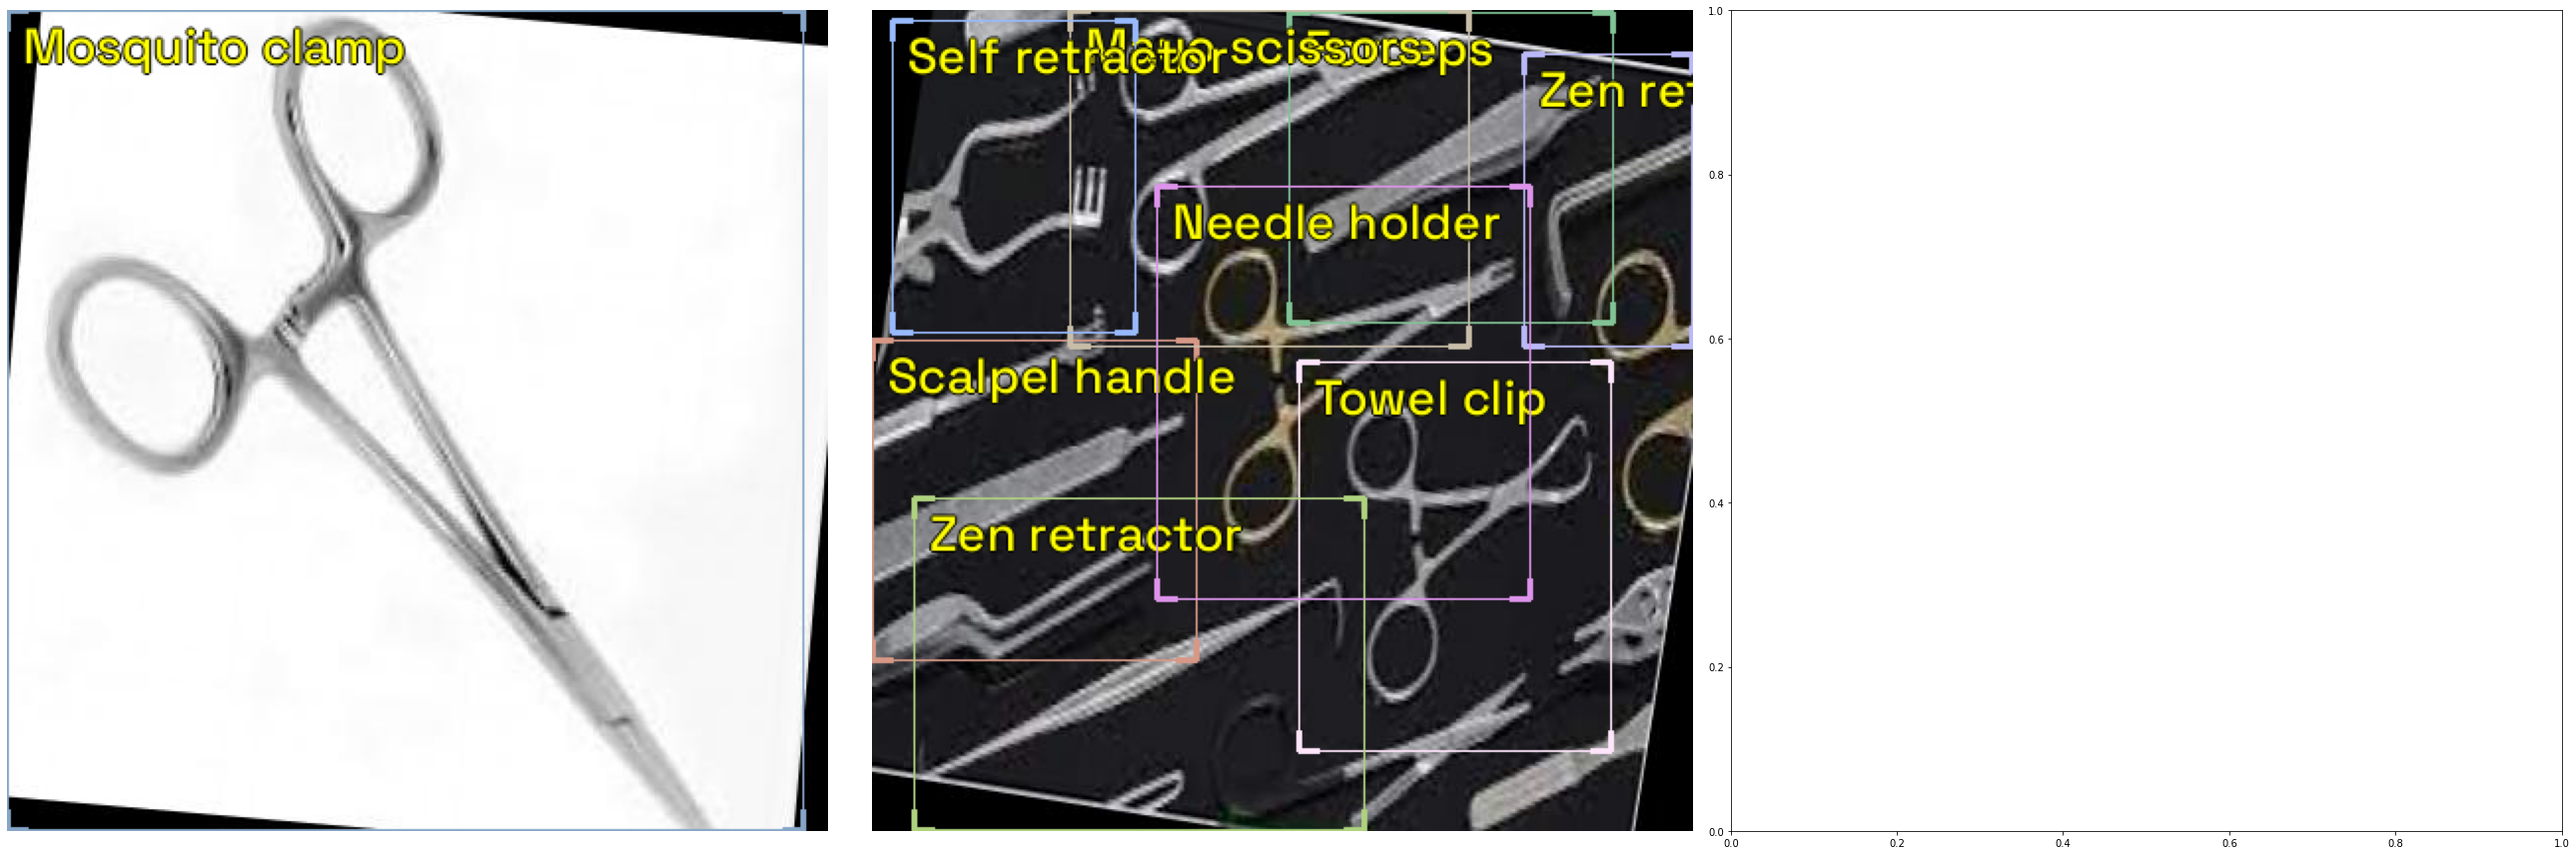

In [41]:
show_records(train_records[1:3], ncols =3, class_map=class_map,
              font_size=25,
            label_color = '#ffff00')

In [42]:
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

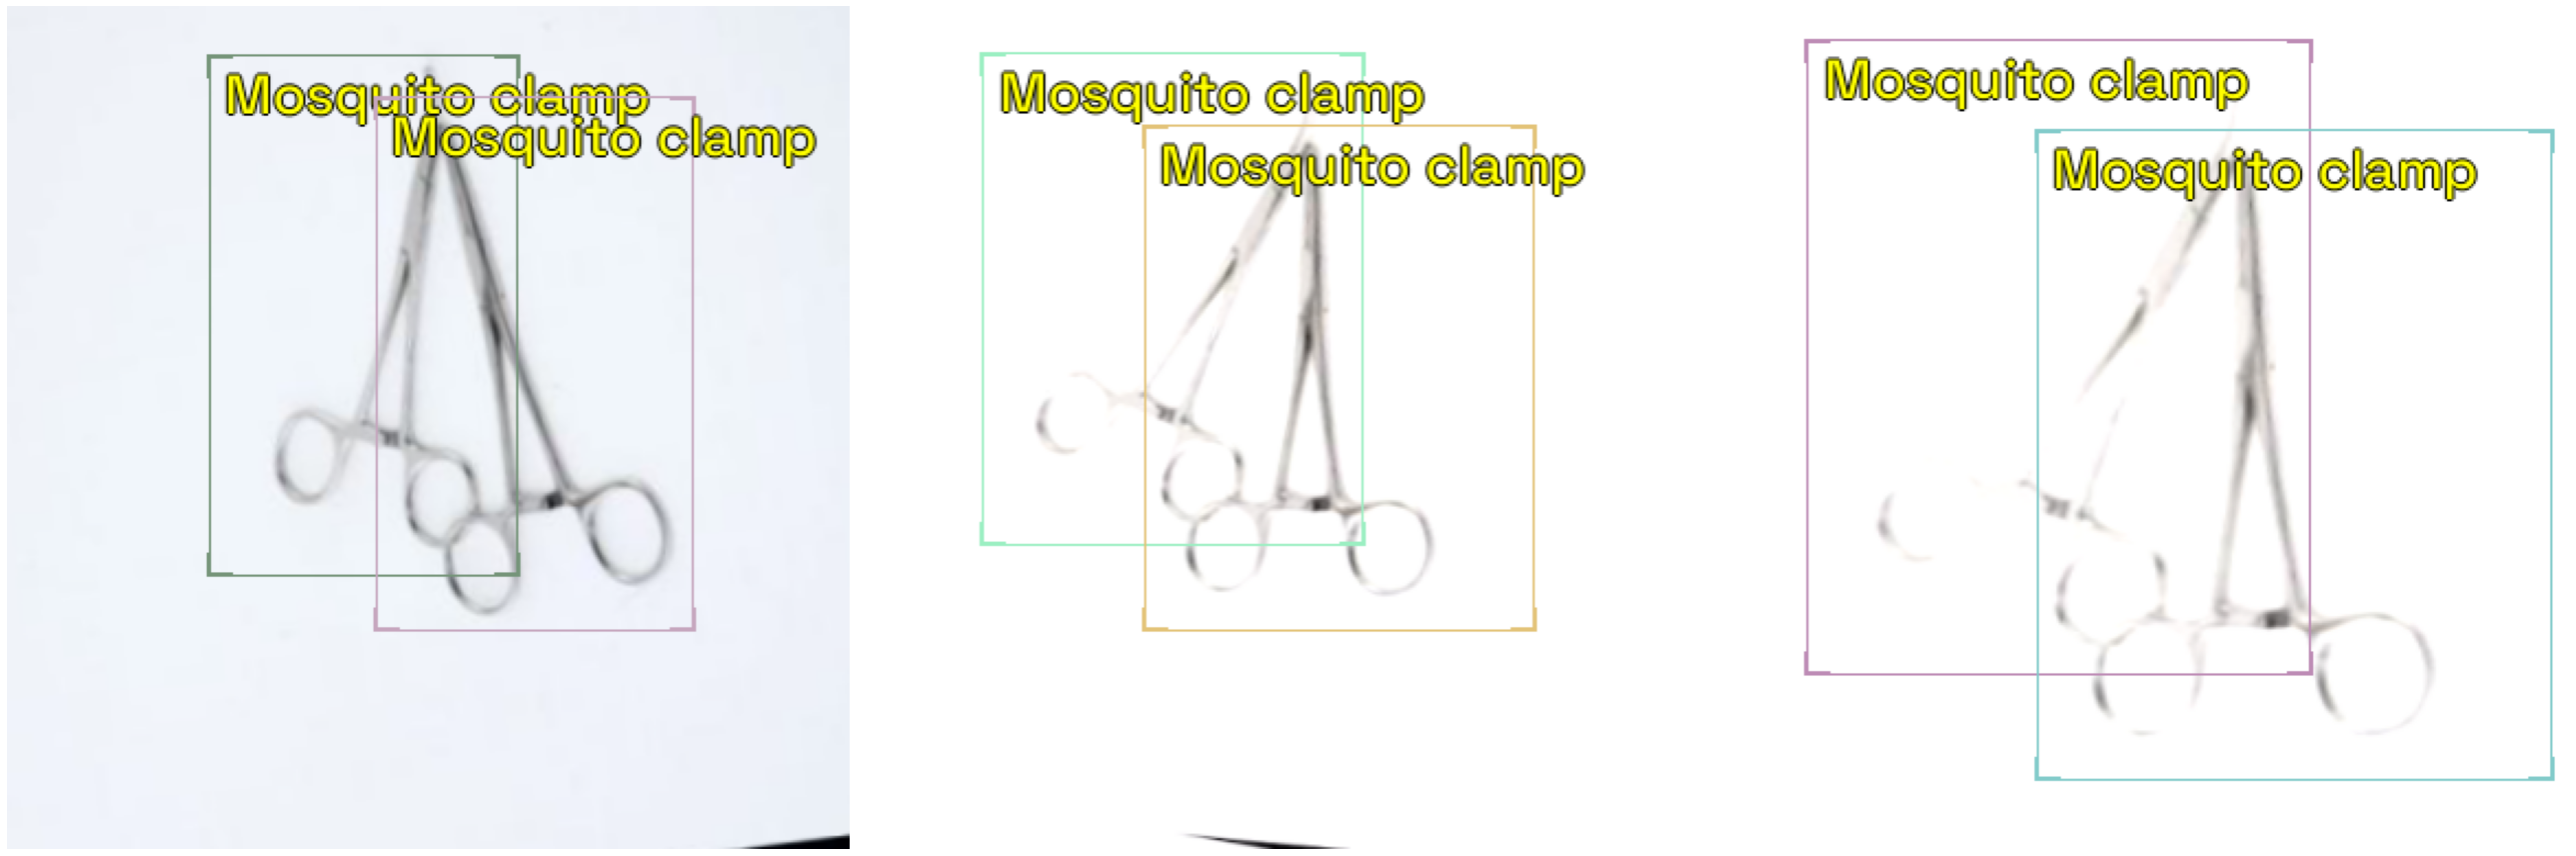

In [43]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, class_map = class_map, 
             denormalize_fn = denormalize_imagenet, ncols=3,
             font_size=25, label_color = '#ffff00')